# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr

In [5]:
plt.rc('figure', figsize = (5,5))

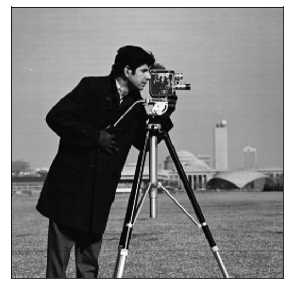

In [6]:
image = data.camera()
show(image)

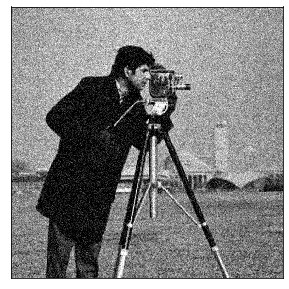

In [7]:
np.random.seed(3)
noisy_image = random_noise(image, mode = 'gaussian', var=0.01)
show(noisy_image)

In [8]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])/256

In [9]:
from util import getbestgpu
device = getbestgpu(1)

GPU device 0 has 7468 MiB left.
--> GPU device 0 was chosen


# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [10]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [11]:
torch.manual_seed(3)
from models.babyunet import BabyUnet
from models.unet import Unet
from models.dncnn import DnCNN

model = DnCNN(1)

In [12]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

556032

In [13]:
image.ravel().shape

(262144,)

# Training

In [14]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [15]:
model = model.to(device)
noisy = noisy.to(device)

In [16]:
losses = []
val_losses = []
best_images = []
best_val_loss = loss_function(noisy, 0*noisy)

for i in range(50):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 5 == 0:
        print("Loss (", i, "): \t", round(loss.item(), 4))
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        print("Val Loss (", i, "): \t", round(val_loss.item(), 5))
        val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_images.append(model(noisy).detach().cpu())
            best_psnr = compare_psnr(np.clip(best_images[-1][0,0].numpy(), 0, 1), img_as_float(image))
            print("Best PSNR: ", np.round(best_psnr, 2))

Loss ( 0 ): 	 0.0017
Val Loss ( 0 ): 	 0.0
Best PSNR:  5.62


/home/yina/envs/n2s/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Loss ( 5 ): 	 0.0003
Val Loss ( 5 ): 	 0.0
Loss ( 10 ): 	 0.0
Val Loss ( 10 ): 	 3e-05
Loss ( 15 ): 	 0.0
Val Loss ( 15 ): 	 1e-05
Loss ( 20 ): 	 0.0
Val Loss ( 20 ): 	 1e-05
Loss ( 25 ): 	 0.0
Val Loss ( 25 ): 	 1e-05
Loss ( 30 ): 	 0.0
Val Loss ( 30 ): 	 1e-05
Loss ( 35 ): 	 0.0
Val Loss ( 35 ): 	 0.0
Best PSNR:  5.62
Loss ( 40 ): 	 0.0
Val Loss ( 40 ): 	 0.0
Loss ( 45 ): 	 0.0
Val Loss ( 45 ): 	 0.0


In [17]:
print(img_as_float(image)[0,0].dtype)

float64


In [18]:
a=np.clip(best_images[-1][0,0].numpy(), 0, 1)
print(a[0,0].dtype)

float32


In [28]:
print(net_input[0,0].dtype)

torch.float32


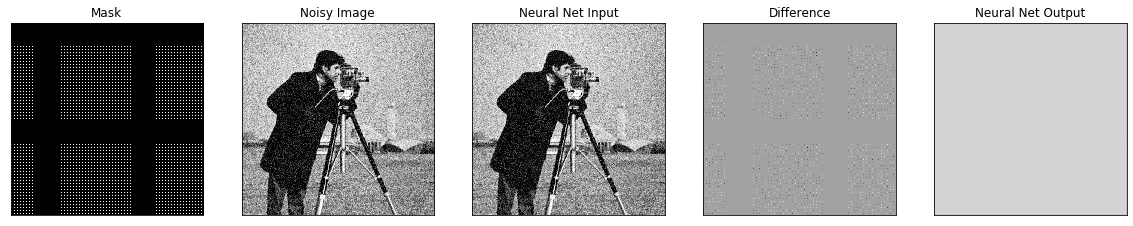

In [19]:
plot_tensors([mask, noisy, net_input, net_input - noisy, best_images[-1][0,0]],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference", "Neural Net Output"])

In [20]:
denoised = np.clip(best_images[-1][0,0].numpy(), 0, 1)

In [21]:
compare_psnr(denoised, img_as_float(image))

5.61962150063118

In [22]:
inset_x_min = 100
inset_x_max = 160
inset_y_min = 230
inset_y_max = 290

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

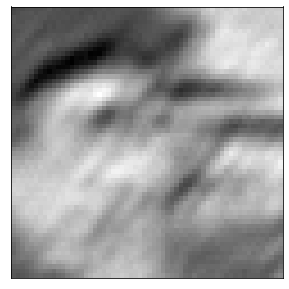

In [23]:
show(get_inset(denoised))

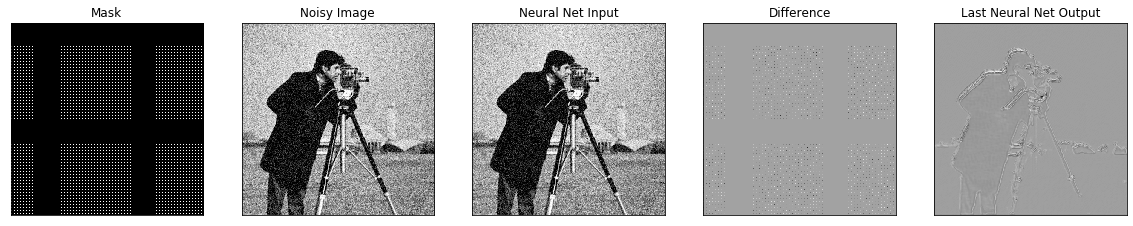

In [24]:
last_output = net_output
plot_tensors([mask, noisy, net_input, net_input - noisy, last_output],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference", "Last Neural Net Output"])

tensor(1.1325e-06, device='cuda:0', grad_fn=<MseLossBackward>)


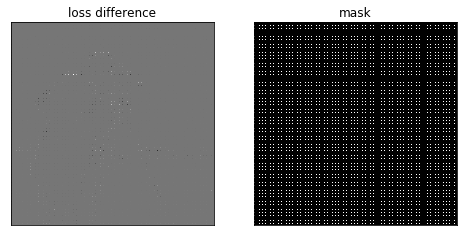

In [25]:
print(loss_function(net_output*mask, noisy*mask))
plot_tensors([net_output*mask - noisy*mask, mask], ["loss difference", "mask"])